In [17]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib import cm
import matplotlib

import pandas as pd
import numpy as np
import csv
import sys

from astropy.io import ascii
import mpld3
from mpld3 import plugins, utils

#my own library for deg_hr, hr_deg
from ch_py import *

%matplotlib inline
#pylab.rcParams['figure.figsize'] = 8, 5

import seaborn as sns
sns.set(context='talk',style='ticks',font='serif',palette='muted',rc={"xtick.direction":"in","ytick.direction":"in"})
#mpld3.enable_notebook()
#mpld3.disable_notebook()

In [18]:
#function to remove all non-numbers characters into Nan
def func(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

In [19]:
print hr_deg('15h59m11.9s', '+20d45m31s')
deg_hr(0.11,0.333)

(239.79958333333335, 20.75861111111111)


'0h0m26.40s +0d19m58.80s'

## Set up the Final Database

In [20]:
final = pd.read_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final3.csv',\
                    keep_default_na=False, na_values=[""])
print final.shape, final.dropna().shape

(9784, 35) (3528, 35)


In [21]:
#flag 1 (NVSS 1.4 GHz) and 2 (SUMSS 843 MHz) for different catalogs

#fixed the ratio #edit 1/1/2017
alpha=-1.3
ratio=(1.4/0.843)**alpha
final['df_radio_n'] = final['df_radio']
#final.loc[final['flag']==2,'df_radio_n'] = final.loc[final['flag']==2,'df_radio']*ratio
final.loc[final['flag']==1,'df_radio_n'] = final.loc[final['flag']==1,'df_radio']*ratio

#Convert w1, ew1 to flux 
#convert Mab = Mvega+2.699 Jy, erg s-1 cm-2 Hz-1
final.loc[:,'wi_f']=3631.*1.0e-23*10.**(-(final.loc[:,'w4']+6.620)/2.5) # F0=3631 Jy, 
final.loc[:,'ewi_f']=3631.*1.0e-23*(10.**(-(final.loc[:,'w4']+final.loc[:,'ew4']+6.620)/2.5)-\
                                    10.**(-(final.loc[:,'w4']-final.loc[:,'ew4']+6.620)/2.5))/2.0  

#convert j_m, ej_m to flux, (J: F0=1594 Jy), (H: F0=1024 Jy), (K: F0=666.7) erg s-1 cm-2 Hz-1
final.loc[:,'2m_f']=666.7*1.0e-23*10.**(-(final.loc[:,'k_m'])/2.5)
final.loc[:,'e2m_f']=666.7*1.0e-23*(10.**(-(final.loc[:,'k_m']+final.loc[:,'ek_m'])/2.5)-\
                                    10.**(-(final.loc[:,'k_m']-final.loc[:,'ek_m'])/2.5))/2.0

#convert ROSAT to flux
#final.loc[:,'x_f']=final.loc[:,'xc']*5.6e-12/1.45e18 #(2.3 keV/h = 1.45e18 Hz)
final.loc[:,'x_f']=final.loc[:,'xc']*1.0e-11/5.56e17 #(2.3 keV/h = 5.56e17 Hz)
final.loc[:,'ex_f']=final.loc[:,'exc']*1.0e-11/5.56e17

#convert Radio data
final.loc[:,'rad_f']=final.loc[:,'f_radio_n']*1.0e-3*1.0e-23
final.loc[:,'erad_f']=final.loc[:,'df_radio_n']*1.0e-3*1.0e-23

#define new columns
final['xray']=np.log10(final['x_f'].values)-np.log10(final['2m_f'].values)
final['mir']=np.log10(final['wi_f'].values)-np.log10(final['2m_f'].values)
final['radio']=np.log10(final['rad_f'].values)-np.log10(final['2m_f'].values)

final['exray']=((0.434*final['ex_f']/final['x_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5
final['emir']=((0.434*final['ewi_f']/final['wi_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5
final['eradio']=((0.434*final['erad_f']/final['rad_f'])**2+(0.434*final['e2m_f']/final['2m_f'])**2)**0.5

In [53]:
final['RA']=(final['ra']+final['ra_radio'])/2.
final['DEC']=(final['dec']+final['dec_radio'])/2.

In [54]:
final.to_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final-01.csv', index=False)

## Define Objects

In [22]:
final = pd.read_csv('/Users/taweewat/Documents/xray_project/result/rosat-rad-final-01.csv',\
                    keep_default_na=False, na_values=[""])
print final.shape, final.dropna().shape

(9784, 52) (3528, 52)


In [23]:
# Brightness Cutoff for k_m > 9 mag
final=final[final['k_m']>9.]
#final=final[final['dist'].values*3600.<20.0]
print final.shape, final.dropna().shape

(6897, 52) (3408, 52)


In [24]:
x=final
#ra='ra_radio'
#dec='dec_radio'

#target=x.loc[(((x.loc[:,'ra']-ra_x)**2+(x.loc[:,'dec']-dec_x)**2)**0.5).idxmin(),:]

In [25]:
i=0
if i==0:
    #our cluster
    ra_x=209.02268
    dec_x=-34.35293
elif i==1:
    #Bullet cluster (found)
    ra_x=104.6292
    dec_x=-55.9469
elif i==2:
    #Abell 2744/Pandora's Cluster (not found)
    ra_x=3.5792
    dec_x=-30.3894
elif i==3:
    #Seyfert's Sextet (not found)
    ra_x, dec_x=hr_deg('15h59m11.9s', '+20d45m31s')
elif i==4:
    #M81 (found)
    ra_x, dec_x=hr_deg('09h55m33.2s', '+69d03m55s')
elif i==5:
    #M1 (not found)
    ra_x, dec_x=hr_deg('05h34m32.0s', '+22d00m52s')
elif i==6:
    #El Gordo (not found)
    ra_x=15.7208
    dec_x=-49.2494
elif i==7:
    #Musket Ball Cluster (not found)
    ra_x=139.0625
    dec_x=29.8497
elif i==8:
    #M31 (not found)
    ra_x, dec_x=hr_deg('00h42m44.3s', '+41d16m09s')
    
print deg_hr(ra_x, dec_x)
print (((x.loc[:,'RA']-ra_x)**2+(x.loc[:,'DEC']-dec_x)**2)**0.5)[((
            (x.loc[:,'RA']-ra_x)**2+(x.loc[:,'DEC']-dec_x)**2)**0.5).idxmin()]*3600, '"'

13h56m5.44s -34d21m10.55s
14.3437460417 "


In [26]:
print (target.dec+target.dec_radio)/2.
print deg_hr((target.ra), (target.dec))
print deg_hr((target.ra+target.ra_radio)/2., (target.dec+target.dec_radio)/2.)
print deg_hr((target.ra_radio), (target.dec_radio))

-34.3491
13h56m5.00s -34d20m44.52s
13h56m5.18s -34d20m56.76s
13h56m5.36s -34d21m9.00s


## finding objects and defining region of interests for potential candidates
 **Use final only

In [27]:
def hr_deg(x, y):
    """function name: hr_deg
    input: RA (string h,m,s), DEC (string deg, arcmin, arcsec)
    output:  RA (decimal format), DEC (decimal format)
    """
    h=np.float(x[0:2])
    m=np.float(x[3:5])
    s=np.float(x[6:10])

    d=np.float(y[0:3])
    dm=np.float(y[4:6])
    ds=np.float(y[7:9])

    ra=h*15.+(m/60.)*15.+(s/3600.)*15.
    if d<0:
        dec=d-dm/60.-ds/3600.
    else: 
        dec=d+dm/60.+ds/3600.
    return ra, dec

In [28]:
print 'PKS', hr_deg('13h56m05.3866s','-34d21m10.859s')
print 'RXJ', hr_deg('17h27m23.4692s','+55d10m53.535s')

PKS (209.02208333333334, -34.35277777777778)
RXJ (261.8475, 55.18138888888889)


In [29]:
abell2=final.loc[(((final.loc[:,'RA']-210.258631)**2+(final.loc[:,'DEC']-2.878468)**2)**0.5).idxmin(),:]
ngc=final.loc[(((final.loc[:,'RA']-49.950416)**2+(final.loc[:,'DEC']-41.51166)**2)**0.5).idxmin(),:]
pheo2=final.loc[(((final.loc[:,'RA']-356.18307)**2+(final.loc[:,'DEC']+42.720204)**2)**0.5).idxmin(),:]


pks=final.loc[(((final.loc[:,'RA']-209.02208)**2+(final.loc[:,'DEC']+34.3527777)**2)**0.5).idxmin(),:]
rxj=final.loc[(((final.loc[:,'RA']-261.8475)**2+(final.loc[:,'DEC']-55.1813889)**2)**0.5).idxmin(),:]

In [30]:
print pks[['ra','dec']]
print rxj[['ra','dec']]

ra     209.02083
dec    -34.34570
Name: 8572, dtype: float64
ra     261.84207
dec     55.18042
Name: 9056, dtype: float64


In [13]:
target=final.loc[(((final.loc[:,'RA']-ra_x)**2+(final.loc[:,'DEC']-dec_x)**2)**0.5).idxmin(),:]

In [14]:
deg_hr(target.ra, target.dec)
#13h56m5.44s -34d21m10.55s

'13h56m5.00s -34d20m44.52s'

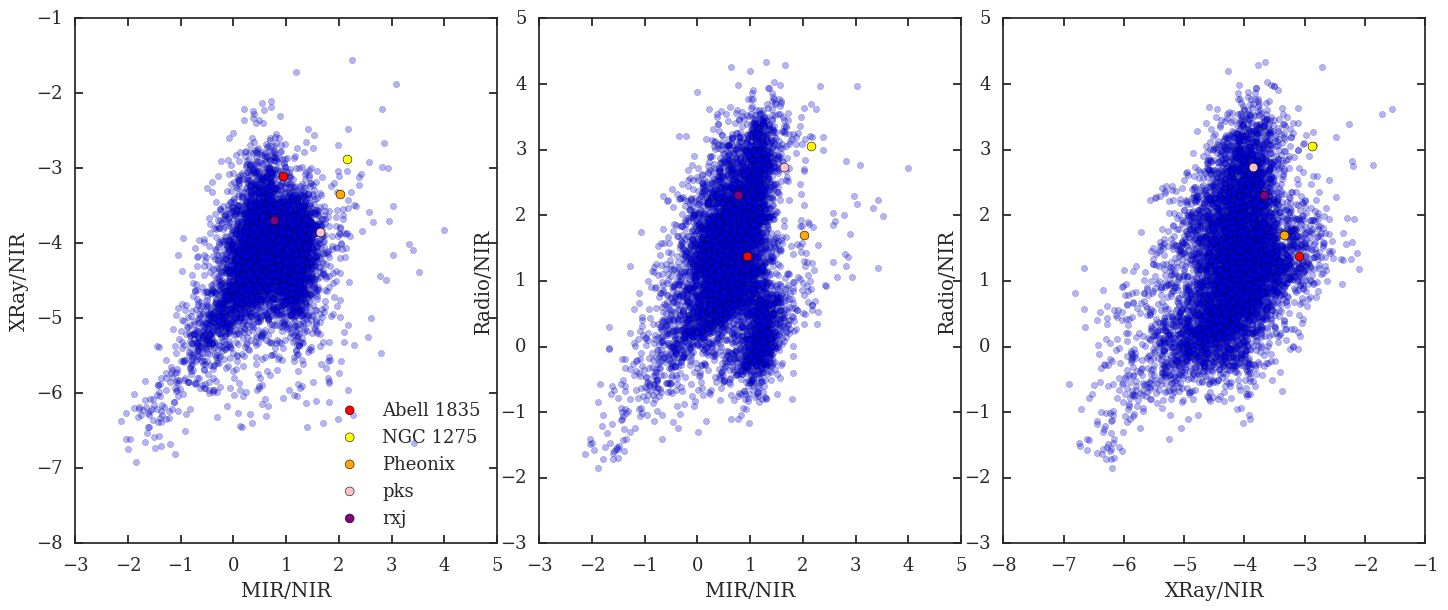

In [37]:
#mpld3.enable_notebook()
mpld3.disable_notebook()

fig, ax = plt.subplots(1, 3, figsize=(15,7))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3)
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='red',label='Abell 1835',s=40.0)
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[0].scatter(pks['mir'],pks['xray'],alpha=1.0,c='pink',label='pks',s=40.0)
ax[0].scatter(rxj['mir'],rxj['xray'],alpha=1.0,c='purple',label='rxj',s=40.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,alpha=0.3)
ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='red',label='Abell1835',s=40.0)
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[1].scatter(pks['mir'],pks['radio'],alpha=1.0,c='pink',label='pks',s=40.0)
ax[1].scatter(rxj['mir'],rxj['radio'],alpha=1.0,c='purple',label='rxj',s=40.0)

ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(xray,radio,alpha=0.3)
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='red',label='Abell1835',s=40.0)
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[2].scatter(pks['xray'],pks['radio'],alpha=1.0,c='pink',label='pks',s=40.0)
ax[2].scatter(rxj['xray'],rxj['radio'],alpha=1.0,c='purple',label='rxj',s=40.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

#plugins.connect(fig, plugins.LinkedBrush(point))

In [36]:
print pheo2.xray, pheo2.radio, pheo2.mir

-3.33712279141 1.69600412709 2.02889579379


### Method 1: Cube uncertainty

### Method 2: ellipsoid 

### Method 3 Vertical Cut
* the method that we end up using at the end with the region of interest from 3, 9, 9 (base on the calculation of uncertainty from ``z_uncertainty``)

In [15]:
#factor of 3 and 9, 9 respectively
#version2: factor of 3.5 and 3.5*3, 3.5*3 respectively
#version3 (12/15/16) mir 3*5, radio 3*3., xray 3

cut1=final
print cut1.shape, cut1.dropna().shape


cut2=final[(final['mir']+final['emir']>pheo2['mir']-np.log10(3*5)) &\
           (final['radio']+final['eradio']>pheo2['radio']-np.log10(3*3.)) &\
           (final['xray']+final['exray']>pheo2['xray']-np.log10(3))]

#cut2=final[(final['mir']>pheo2['mir']-np.log10(3.*3.)) &\
#           (final['radio']>pheo2['radio']-np.log10(3.*3.)) &\
#           (final['xray']>pheo2['xray']-np.log10(3.))]

#def incut(x):        
    
#print pheo2['mir'], pheo2['mir']-
print cut1.shape, cut2.shape
cut=cut2

(6897, 52) (3408, 52)
(6897, 52) (752, 52)


In [16]:
final['mir']

0       0.640896
1      -0.232304
2       0.755296
4       0.323296
6       0.619296
7      -0.240704
8       1.366896
10      0.188496
12     -0.350304
14     -0.063904
15      0.852496
19     -0.739104
20      0.538496
21      1.985296
23      0.360496
24      0.117696
25      1.181296
26      0.592096
27      1.013296
28      0.541296
30      0.484096
31      1.029296
34      1.398896
35      0.770896
37     -0.289904
38      1.279696
39     -0.494304
45      1.187296
49      0.893696
50      0.452496
          ...   
9744    1.044096
9745    1.098096
9746    0.987696
9748    0.982496
9750    2.028896
9751    0.680096
9753    0.416896
9754   -0.685904
9755    0.333696
9756    1.291296
9757    0.128896
9759    1.156496
9760   -0.167104
9761    1.158496
9763    1.067296
9766    0.493296
9767    1.214896
9768    0.335296
9769    0.221296
9770   -0.162704
9771    0.900096
9772    0.949296
9774    0.552896
9775    1.094896
9777   -0.296704
9778    0.892496
9779    0.890896
9781    0.3704

### Find target inside the cut

In [16]:
print 'RXJ', hr_deg('17h27m23.4692s','+55d10m53.535s')

target15=hr_deg('17h27m23.46928s','+55d10m53.5357s')
target_15=cut.loc[(((cut.loc[:,'RA']-261.8475)**2+(final.loc[:,'DEC']-55.1813888889)**2)**0.5).idxmin(),:]
print target15[0], target15[1]

RXJ (261.8475, 55.18138888888889)
261.8475 55.1813888889


In [17]:
target_15[['ra','dec']]

ra     261.84207
dec     55.18042
Name: 9056, dtype: float64

In [18]:
print pheo2['mir']-np.log10(3.5*3.)
print pheo2['radio']-np.log10(3.5*3.)
print pheo2['xray']-np.log10(3.5)

1.00770649472
0.67481482802
-3.88119083576


In [19]:
target_15[['mir','radio','xray']]

mir      0.768896
radio    2.312824
xray    -3.681940
Name: 9056, dtype: float64

In [20]:
cut.shape

(752, 52)

<hr>

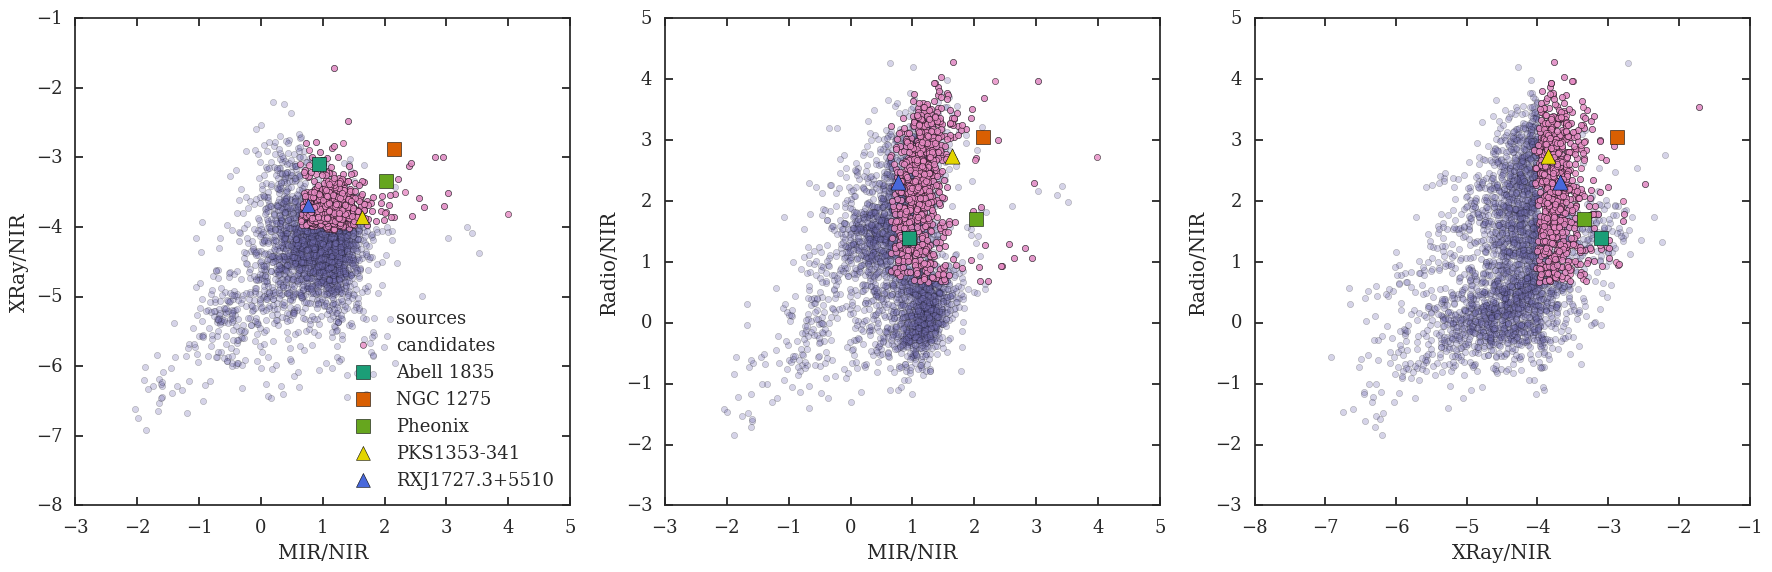

In [30]:
#mpld3.enable_notebook()
mpld3.disable_notebook()
s=6
fig, ax = plt.subplots(1, 3, figsize=(3*s,s))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final.dropna()['mir'].values
xray=final.dropna()['xray'].values
radio=final.dropna()['radio'].values

point=ax[0].scatter(mir,xray,alpha=0.3, c='#7570b3', label='sources',s=20.)
ax[0].scatter(cut['mir'],cut['xray'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='#1b9e77',label='Abell 1835',s=100.0,marker='s')
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[0].scatter(pks['mir'],pks['xray'],alpha=1.0,c='#e3d400',label='PKS1353-341',s=100.0,marker='^')
ax[0].scatter(rxj['mir'],rxj['xray'],alpha=1.0,c='#4868db',label='RXJ1727.3+5510',s=100.0,marker='^')


#ax[0].scatter(target['mir'],target['xray'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
ax[0].legend(loc='lower right')

point=ax[1].scatter(mir,radio,alpha=0.3, c='#7570b3', label='sources',s=20.)
ax[1].scatter(cut['mir'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='#1b9e77',label='Abell 1835',s=100.0,marker='s')
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[1].scatter(pks['mir'],pks['radio'],alpha=1.0,c='#e3d400',label='PKS1353-341',s=120.0,marker='^')
ax[1].scatter(rxj['mir'],rxj['radio'],alpha=1.0,c='#4868db',label='RXJ1727.3+5510',s=120.0,marker='^')


#ax[1].scatter(target['mir'],target['radio'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(xray,radio,alpha=0.3, c='#7570b3', label='sources',s=20.)
ax[2].scatter(cut['xray'],cut['radio'],alpha=0.8,c='#e78ac3',label='candidates',s=20)
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='#1b9e77',label='Abell 1835',s=100.0,marker='s')
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='#d95f02',label='NGC 1275',s=100.0,marker='s')
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='#66a61e',label='Pheonix',s=100.0,marker='s')
ax[2].scatter(pks['xray'],pks['radio'],alpha=1.0,c='#e3d400',label='PKS1353-341',s=120.0,marker='^')
ax[2].scatter(rxj['xray'],rxj['radio'],alpha=1.0,c='#4868db',label='RXJ1727.3+5510',s=120.0,marker='^')

#ax[2].scatter(target['xray'],target['radio'],alpha=1.0,c='#e6ab02',label='target',s=100.0,marker='s')
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')

plt.tight_layout()

#plugins.connect(fig, plugins.LinkedBrush(point))

plt.savefig('/Users/taweewat/Documents/chandra/figure/total_object.pdf', bbox_inches='tight')

## How to use plotly with office option

In [42]:
import plotly as plotly

import plotly.plotly as py
from plotly.graph_objs import *

#print plotly.__version__            # version 1.9.x required
plotly.offline.init_notebook_mode()


trace0 = Scatter3d(
    x=mir,  # x coords
    y=radio,  # y coords
    z=xray,  # z coords
    mode='markers',
    name='candidates',
    marker=Marker(color='blue',symbol='dot',size=2,opacity=0.3)
)

def ellipse(u,v):
    x=pheo2['mir']+1.079*np.cos(u)*np.cos(v)
    y=pheo2['radio']+1.079*np.cos(u)*np.sin(v)
    z=pheo2['xray']+0.602*np.sin(u)
    return x,y,z

u=np.linspace(-np.pi/2,np.pi/2,200)
v=np.linspace(-np.pi,np.pi,200)
ugrid, vgrid = np.meshgrid(u,v)

x,y,z=ellipse(ugrid, vgrid)

#surface = Surface(x=x, y=y, z=z,opacity=0.8)
surface = Surface(x=x, y=y, z=z,opacity=0.8,showscale=False)#,colorscale='Greys')#,\
                 #contours=dict(x=dict(show=True, width=1),\
                 #              y=dict(show=True, width=1),\
                 #              z=dict(show=True, width=1)))

trace1 = Scatter3d(
    x=[abell2['mir']],  # x coords
    y=[abell2['radio']],  # y coords
    z=[abell2['xray']],  # z coords
    mode='markers',
    name='Abell',
    marker=Marker(color='red',symbol='dot',size=5,opacity=1.0)
)

trace2 = Scatter3d(
    x=[ngc['mir']],  # x coords
    y=[ngc['radio']],  # y coords
    z=[ngc['xray']],  # z coords
    mode='markers',
    name='NGC',
    marker=Marker(color='green',symbol='dot',size=5,opacity=1.0)
)

trace3 = Scatter3d(
    x=[pheo2['mir']],  # x coords
    y=[pheo2['radio']],  # y coords
    z=[pheo2['xray']],  # z coords
    mode='markers',
    name='Pheonix',
    marker=Marker(color='orange',symbol='dot',size=5,opacity=1.0)
)

trace5 = Scatter3d(
    x=[target['mir']],  # x coords
    y=[target['radio']],  # y coords
    z=[target['xray']],  # z coords
    mode='markers',
    name='Target',
    marker=Marker(color='purple',symbol='dot',size=5,opacity=1.0)
)

trace4 = Scatter3d(
    x=cut['mir'],  # x coords
    y=cut['radio'],  # y coords
    z=cut['xray'],  # z coords
    mode='markers',
    name='Cut',
    marker=Marker(color='violet',symbol='dot',size=3,opacity=1.0)
    #marker=Marker(color=cut['inside'],symbol='diamond',size=4,opacity=0.8,\
    #              colorscale='Reds',showscale=True,cmax=cut['inside'].max())
)


layout = Layout(
    title='Plot of Xray, MIR, Radio',
    scene=Scene(
        xaxis=XAxis(title='MIR/NIR'),
        yaxis=YAxis(title='Radio/NIR'),
        zaxis=ZAxis(title='Xray/NIR')))

# Package the trace dictionary into a data object
data = Data([trace0,trace1,trace2,trace3,trace5,trace4])#,surface])

fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)
#py.iplot(fig)

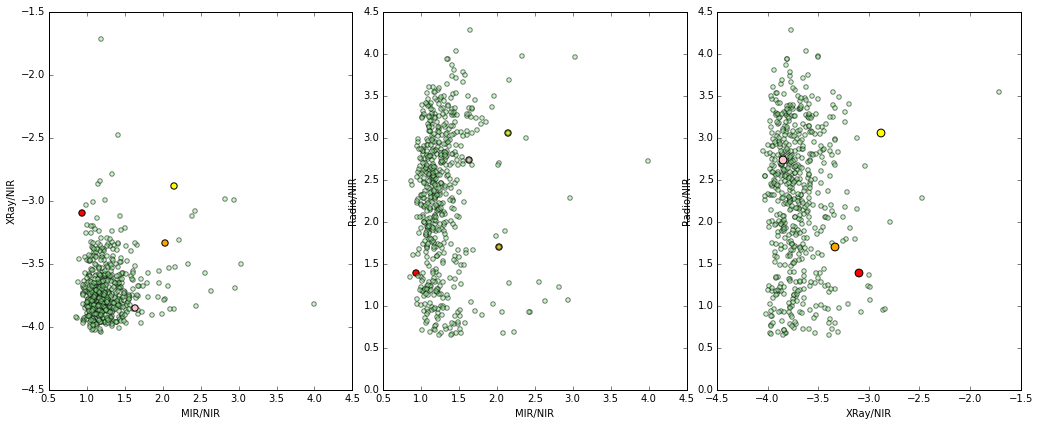

In [39]:
#mpld3.enable_notebook()
mpld3.disable_notebook()

fig, ax = plt.subplots(1, 3, figsize=(15,7))#, sharex="col", sharey="row")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.95,hspace=0.1, wspace=0.1)

mir=final['mir'].values
xray=final['xray'].values
radio=final['radio'].values

point=ax[0].scatter(cut['mir'],cut['xray'],alpha=0.5,c='lightgreen',label='Cut')
ax[0].scatter(abell2['mir'],abell2['xray'],alpha=1.0,c='red',label='Abell',s=40.0)
ax[0].scatter(ngc['mir'],ngc['xray'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[0].scatter(pheo2['mir'],pheo2['xray'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[0].scatter(target['mir'],target['xray'],alpha=1.0,c='pink',label='target',s=40.0)
ax[0].set_xlabel('MIR/NIR')
ax[0].set_ylabel('XRay/NIR')
#ax[0].legend(loc='best')

point=ax[1].scatter(abell2['mir'],abell2['radio'],alpha=1.0,c='red',label='Abell',s=40.0)
ax[1].scatter(ngc['mir'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=40.0)
ax[1].scatter(pheo2['mir'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=40.0)
ax[1].scatter(target['mir'],target['radio'],alpha=1.0,c='pink',label='target',s=40.0)
ax[1].scatter(cut['mir'],cut['radio'],alpha=0.5,c='lightgreen',label='Cut')
ax[1].set_xlabel('MIR/NIR')
ax[1].set_ylabel('Radio/NIR')

point=ax[2].scatter(cut['xray'],cut['radio'],alpha=0.5,c='lightgreen',label='Cut')
ax[2].scatter(abell2['xray'],abell2['radio'],alpha=1.0,c='red',label='Abell',s=60.0)
ax[2].scatter(ngc['xray'],ngc['radio'],alpha=1.0,c='yellow',label='NGC 1275',s=60.0)
ax[2].scatter(pheo2['xray'],pheo2['radio'],alpha=1.0,c='orange',label='Pheonix',s=60.0)
ax[2].scatter(target['xray'],target['radio'],alpha=1.0,c='pink',label='target',s=60.0)
ax[2].set_xlabel('XRay/NIR')
ax[2].set_ylabel('Radio/NIR')
#ax[2].axis([-4.5,-2.5,0,4.5])


plugins.connect(fig, plugins.LinkedBrush(point))

In [25]:
for i in range(5):
    print cut['RA'].values[i], cut['DEC'].values[i] 
    
#cut['RA']

133.04933 76.4540577778
34.3791233333 73.8256644445
137.121913334 72.2754022222
156.653913334 70.5444716666
114.088956666 65.2220166667


## Looking at these objects
(under construction --> later change to SDSS method in another file)

## Output the cut file

In [73]:
#cut.to_csv('/Users/taweewat/Documents/xray_project/result/cut-01.csv', index=False)
cut.to_csv('/Users/taweewat/Documents/xray_project/result/cut-05.csv', index=False)

## Extra analysis about the distance 
(update 2/1/2016)

In [16]:
f=final.dropna()

In [17]:
dist=((f['ra']-f['ra_radio'])**2+(f['dec']-f['dec_radio'])**2)**0.5*3600.

(array([ 8.,  2.,  6.,  4.,  2.,  0.,  1.,  1.,  0.,  1.]),
 array([ 30.22864612,  31.07816397,  31.92768182,  32.77719967,
         33.62671752,  34.47623537,  35.32575322,  36.17527107,
         37.02478891,  37.87430676,  38.72382461]),
 <a list of 10 Patch objects>)

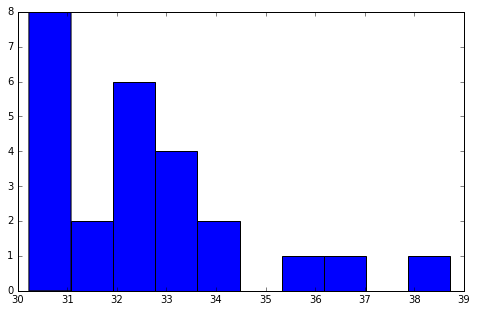

In [26]:
plt.hist([i for i in dist if i > 30.])

In [19]:
c = pd.read_csv('/Users/taweewat/Documents/xray_project/result/cut-01.csv',\
                keep_default_na=False, na_values=[""])

In [21]:
dist_c=dist=((c['ra']-c['ra_radio'])**2+(c['dec']-c['dec_radio'])**2)**0.5*3600.

(array([  70.,  110.,  101.,   85.,   69.,   48.,   40.,   22.,   13.,    3.]),
 array([  1.01199996,   4.78318243,   8.55436489,  12.32554736,
         16.09672982,  19.86791229,  23.63909475,  27.41027722,
         31.18145968,  34.95264215,  38.72382461]),
 <a list of 10 Patch objects>)

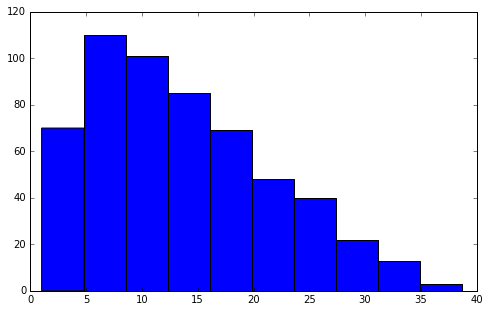

In [23]:
plt.hist(dist_c)

In [10]:
c = pd.read_csv('/Users/taweewat/Documents/xray_project/result/cut-03.csv',\
                keep_default_na=False, na_values=[""])
print c.shape

(757, 52)


In [ ]:
hr_deg(0,0)

In [38]:
print deg_hr((target.ra), (target.dec))

13h56m5.00s -34d20m44.52s


In [61]:
hr_deg('10h14m27.9s','+31d04m05s')

(153.6225, 31.07027777777778)